In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!pip install fastai==1.0.44

    100% |████████████████████████████████| 184kB 8.6MB/s 
  Found existing installation: fastai 1.0.51
    Uninstalling fastai-1.0.51:
      Successfully uninstalled fastai-1.0.51


In [3]:
from fastai.vision import *

In [4]:
import pandas as pd
import glob

In [5]:
path_images = Path("../input/train")
path_lbl = path_images

In [6]:
fnames = glob.glob('../input/train/*[!_mask].tif')
print(fnames[:3])
len(fnames)

['../input/train/32_94.tif', '../input/train/47_59.tif', '../input/train/44_37.tif']


5635

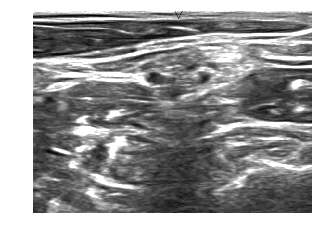

In [7]:
img_f = fnames[3]
img = open_image(img_f)
img.show(figsize=(5,5))

In [8]:
lbl_names = glob.glob('../input/train/*_mask.tif')
print(lbl_names[:3])
len(lbl_names)

['../input/train/45_107_mask.tif', '../input/train/12_96_mask.tif', '../input/train/14_18_mask.tif']


5635

In [9]:
def get_y_fn(x):
    x = Path(x)
    return path_lbl/f'{x.stem}_mask{x.suffix}'

In [10]:
get_y_fn(fnames[0])

PosixPath('../input/train/32_94_mask.tif')

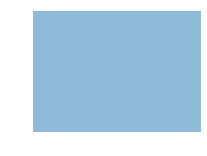

In [11]:
mask = open_mask(get_y_fn(img_f),div=True)
mask.show()

In [12]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([420, 580]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [13]:
torch.max(mask.data)

tensor(0)

In [14]:
filter_func = lambda x: str(x) in fnames

In [15]:
#size = src_size//4
size = 128

In [16]:
from fastai.utils.mem import *
#free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
#if free > 8200: bs=8
#else:           bs=4
#print(f"using bs={bs}, have {free}MB of GPU RAM free")
bs=8

In [17]:
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom


In [18]:
codes = ['0','1']
src = (SegItemListCustom.from_folder(path_images)
       .filter_by_func(filter_func)
       .random_split_by_pct()
       .label_from_func(get_y_fn,classes=codes))

In [19]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
data.path = Path('.')

In [20]:
#data.show_batch(2, figsize=(10,7))

In [21]:
def dice(input:Tensor, targs:Tensor, iou:bool=False)->Rank0Tensor:
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
    n = targs.shape[0]
    #print(n)
    input = input.argmax(dim=1).view(n,-1)
    #print(n)
    targs = targs.view(n,-1)
    #print(targs)
    intersect = (input * targs).sum().float()
    union = (input+targs).sum().float()
    if not iou: return (2. * intersect / union if union > 0 else union.new([1.]).squeeze())
    else: return intersect / (union-intersect+1.0)

In [22]:
#dice(mask.data,mask.data)

In [23]:
learn = unet_learner(data, models.resnet50, metrics=[dice])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.torch/models/resnet50-19c8e357.pth
102502400it [00:04, 25440263.16it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06


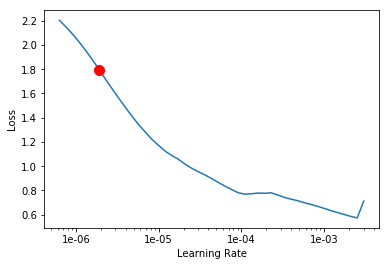

In [24]:
lr_find(learn)
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(10,max_lr = 1e-5)

epoch,train_loss,valid_loss,dice
1,0.059454,0.047779,0.094085
2,0.045691,0.036488,0.420926
3,0.042686,0.059687,0.512095
4,0.038437,0.032789,0.530427
5,0.035080,0.036961,0.336199


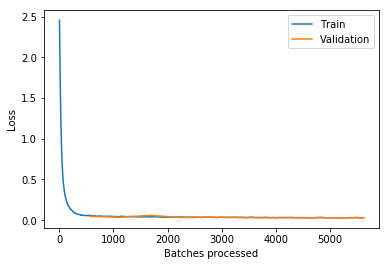

In [26]:
learn.recorder.plot_losses()

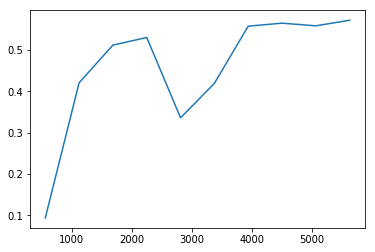

In [27]:
learn.recorder.plot_metrics()

In [28]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06


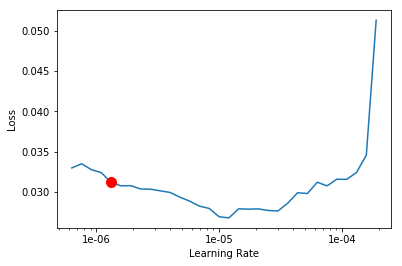

In [29]:
learn.lr_find()
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(10,max_lr = slice(1e-6,1e-4))

epoch,train_loss,valid_loss,dice
1,0.035569,0.033278,0.564552
2,0.040034,0.034949,0.444398
3,0.038673,0.038132,0.554080
4,0.036039,0.037676,0.578617
5,0.035802,0.031749,0.558022
6,0.032548,0.030142,0.560983
